The purpose of this notebook ist to estimate the energy consumption in BTU (British Thermal Units) for heating, cooling, hot water and pool.

First, we import the necessary libraries and the dataset.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt


step=1 # step size for iterations. The lower the slower.
fig_width = 7.5 # width of figures
fig_height = 5 # height of figures
k=25 # number of largest feature importances


#import os
#os.path.join('input/2015-residential-energy-consumption-survey/')


In [3]:
houses_df=pd.read_csv(r"C:\Users\alkou\Documents\GitHub\Scattered-Directive\house_energy_consumption\recs2015_public_v4.csv")
houses_df.head()

,DOEID,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,...,ZELAMOUNT,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT
0,10001,4,10,METRO,U,2,0,0,0,-2,...,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
1,10002,3,7,NONE,R,2,0,0,0,-2,...,1,NaN,-2,-2,137.45,-2,-2,91.33,-2,-2
2,10003,3,6,METRO,U,2,0,1,0,1,...,0,100.14,1,0,137.45,-2,-2,91.33,-2,-2
3,10004,2,4,MICRO,C,2,0,1,0,1,...,0,NaN,-2,-2,137.45,-2,-2,91.33,2,0
4,10005,1,2,METRO,U,2,0,1,0,0,...,0,102.83,1,0,137.45,-2,-2,91.33,-2,-2


The dataset has a number features of US-American residential buildings as well as a number of energy consumption metrics. 
These are especially features around:
- the building itself, 
- where it is located with the respective climate implications, 
- the structure of the air and water heating/cooling system,
- the use of the heating/cooling system,
- the residents of the building
- some electrical devices.

The details on the field definitions can be taken from the also attached file 'codebook_publicv4.xlsx'. The dataset is quite comprehensive and we won't need all the data, so we will delete the following column types:
1) Primary key (DOEID), 

2) energy use columns, we don't need,

3) indicator columns for imputed data (Z-columns) and

4) columns with data for electronic devices.

In [ ]:
# check if colunms contain null-values. If yes, replace with 0.
if houses_df[['BTUELSPH','BTUFOSPH','BTUNGSPH','BTULPSPH', 'BTUELCOL','BTUELWTH','BTUFOWTH','BTUNGWTH',
                                    'BTULPWTH','BTUELAHUCOL','BTUNGPLHEAT','BTUELHTBHEAT','BTUNGHTBHEAT','BTUELHTBPMP']].isnull().values.any()==True:
    print('Some columns contain Null values.')
    houses_df[['BTUELSPH','BTUFOSPH','BTUNGSPH','BTULPSPH', 'BTUELCOL','BTUELWTH','BTUFOWTH','BTUNGWTH',
                                    'BTULPWTH','BTUELAHUCOL','BTUNGPLHEAT','BTUELHTBHEAT','BTUNGHTBHEAT','BTUELHTBPMP']].fillna(0)
else: print('No columns contain Null values.')
print('Number of cells before deletion of energy usage: ',houses_df.shape)

# calculate total relevant BTU consumption and delete energy consumption cells afterwards.
houses_df['REL_TOTALBTU']=houses_df[['BTUELSPH','BTUFOSPH','BTUNGSPH','BTULPSPH', 'BTUELCOL','BTUELWTH','BTUFOWTH','BTUNGWTH',
                                    'BTULPWTH','BTUELAHUCOL','BTUNGPLHEAT','BTUELHTBHEAT','BTUNGHTBHEAT','BTUELHTBPMP']].sum(axis=1)
houses_df=houses_df.drop(columns=['DOEID','NWEIGHT','BRRWT1','BRRWT2','BRRWT3','BRRWT4','BRRWT5','BRRWT6','BRRWT7','BRRWT8','BRRWT9','BRRWT10',
                        'BRRWT11','BRRWT12','BRRWT13','BRRWT14','BRRWT15','BRRWT16','BRRWT17','BRRWT18','BRRWT19','BRRWT20','BRRWT21',
                        'BRRWT22','BRRWT23','BRRWT24','BRRWT25','BRRWT26','BRRWT27','BRRWT28','BRRWT29','BRRWT30','BRRWT31','BRRWT32',
                        'BRRWT33','BRRWT34','BRRWT35','BRRWT36','BRRWT37','BRRWT38','BRRWT39','BRRWT40','BRRWT41','BRRWT42','BRRWT43',
                        'BRRWT44','BRRWT45','BRRWT46','BRRWT47','BRRWT48','BRRWT49','BRRWT50','BRRWT51','BRRWT52','BRRWT53','BRRWT54',
                        'BRRWT55','BRRWT56','BRRWT57','BRRWT58','BRRWT59','BRRWT60','BRRWT61','BRRWT62','BRRWT63','BRRWT64','BRRWT65',
                        'BRRWT66','BRRWT67','BRRWT68','BRRWT69','BRRWT70','BRRWT71','BRRWT72','BRRWT73','BRRWT74','BRRWT75','BRRWT76',
                        'BRRWT77','BRRWT78','BRRWT79','BRRWT80','BRRWT81','BRRWT82','BRRWT83','BRRWT84','BRRWT85','BRRWT86','BRRWT87',
                        'BRRWT88','BRRWT89','BRRWT90','BRRWT91','BRRWT92','BRRWT93','BRRWT94','BRRWT95','BRRWT96',
                        'KWH','KWHSPH','KWHCOL','KWHWTH','KWHRFG','KWHRFG1','KWHRFG2','KWHFRZ','KWHCOK','KWHMICRO','KWHCW','KWHCDR',
                        'KWHDWH','KWHLGT','KWHTVREL','KWHTV1','KWHTV2','KWHAHUHEAT','KWHAHUCOL','KWHEVAPCOL','KWHCFAN','KWHDHUM',
                        'KWHHUM','KWHPLPMP','KWHHTBPMP','KWHHTBHEAT','KWHNEC','BTUEL','BTUELSPH','BTUELCOL','BTUELWTH','BTUELRFG',
                        'BTUELRFG1','BTUELRFG2','BTUELFRZ','BTUELCOK','BTUELMICRO','BTUELCW','BTUELCDR','BTUELDWH','BTUELLGT',
                        'BTUELTVREL','BTUELTV1','BTUELTV2','BTUELAHUHEAT','BTUELAHUCOL','BTUELEVAPCOL','BTUELCFAN','BTUELDHUM',
                        'BTUELHUM','BTUELPLPMP','BTUELHTBPMP','BTUELHTBHEAT','BTUELNEC','DOLLAREL','DOLELSPH','DOLELCOL','DOLELWTH',
                        'DOLELRFG','DOLELRFG1','DOLELRFG2','DOLELFRZ','DOLELCOK','DOLELMICRO','DOLELCW','DOLELCDR','DOLELDWH',
                        'DOLELLGT','DOLELTVREL','DOLELTV1','DOLELTV2','DOLELAHUHEAT','DOLELAHUCOL','DOLELEVAPCOL','DOLELCFAN',
                        'DOLELDHUM','DOLELHUM','DOLELPLPMP','DOLELHTBPMP','DOLELHTBHEAT','DOLELNEC','CUFEETNG','CUFEETNGSPH',
                        'CUFEETNGWTH','CUFEETNGCOK','CUFEETNGCDR','CUFEETNGPLHEAT','CUFEETNGHTBHEAT','CUFEETNGNEC','BTUNG','BTUNGSPH',
                        'BTUNGWTH','BTUNGCOK','BTUNGCDR','BTUNGPLHEAT','BTUNGHTBHEAT','BTUNGNEC','DOLLARNG','DOLNGSPH','DOLNGWTH',
                        'DOLNGCOK','DOLNGCDR','DOLNGPLHEAT','DOLNGHTBHEAT','DOLNGNEC','GALLONLP','GALLONLPSPH','GALLONLPWTH',
                        'GALLONLPCOK','GALLONLPCDR','GALLONLPNEC','BTULP','BTULPSPH','BTULPWTH','BTULPCOK','BTULPCDR','BTULPNEC',
                        'DOLLARLP','DOLLPSPH','DOLLPWTH','DOLLPCOK','DOLLPCDR','DOLLPNEC','GALLONFO','GALLONFOSPH','GALLONFOWTH',
                        'GALLONFONEC','BTUFO','BTUFOSPH','BTUFOWTH','BTUFONEC','DOLLARFO','DOLFOSPH','DOLFOWTH','DOLFONEC','TOTALBTU',
                        'TOTALDOL','TOTALBTUSPH','TOTALDOLSPH','TOTALBTUWTH','TOTALDOLWTH','TOTALBTUCOK','TOTALDOLCOK','TOTALBTUCDR',
                        'TOTALDOLCDR','TOTALBTUPL','TOTALDOLPL','TOTALBTUHTB','TOTALDOLHTB','TOTALBTUNEC','TOTALDOLNEC','WOODAMT',
                        'WOODBTU','PELLETAMT','PELLETBTU','ELXBTU','PERIODEL','NGXBTU','PERIODNG','FOXBTU','PERIODFO','LPXBTU',
                        'PERIODLP'])
print('Number of cells after deletion of unnecessary energy usage columns: ',houses_df.shape)

# deleting Z-columns
houses_df=houses_df.drop(columns=['ZADQINSUL', 'ZAGECDRYER', 'ZAGECENAC', 'ZAGECWASH', 'ZAGEDW', 'ZAGEFRZR', 'ZAGERFRI1', 'ZAGERFRI2','ZAIRCOND', 'ZALTFUELPEV', 'ZAMTMICRO', 'ZAPPOTHER', 'ZATHOME', 'ZATTCCOOL', 'ZATTCHEAT', 'ZATTIC', 
                                  'ZATTICFIN', 'ZBACKUP', 'ZBASECOOL', 'ZBASEFIN', 'ZBASEHEAT', 'ZBEDROOMS', 'ZBLENDER', 'ZCABLESAT', 
                                  'ZCELLAR', 'ZCELLPHONE', 'ZCENACHP', 'ZCOFFEE', 'ZCOLDMA', 'ZCOMBODVR', 'ZCOOKTUSE', 'ZCOOLTYPE', 
                                  'ZCROCKPOT', 'ZCWASHER', 'ZDESKTOP', 'ZDISHWASH', 'ZDNTHEAT', 'ZDOOR1SUM', 'ZDRAFTY', 'ZDRYER', 
                                  'ZDRYRFUEL', 'ZDRYRUSE', 'ZDUALCOOKTFUEL', 'ZDUALOVENFUEL', 'ZDVD', 'ZDWASHUSE', 'ZDWCYCLE', 
                                  'ZEDUCATION', 'ZELPAY', 'ZELPERIPH', 'ZEMPLOYHH', 'ZENERGYASST', 'ZENERGYASST11', 'ZENERGYASST12', 
                                  'ZENERGYASST13', 'ZENERGYASST14', 'ZENERGYASST15', 'ZENERGYASSTOTH', 'ZEQUIPAGE', 'ZEQUIPAUX', 
                                  'ZEQUIPAUXTYPE', 'ZEQUIPM', 'ZEQUIPMUSE', 'ZFOODPROC', 'ZFOPAY', 'ZFUELAUX', 'ZFUELH2O', 
                                  'ZFUELH2O2', 'ZFUELHEAT', 'ZFUELPOOL', 'ZFUELTUB', 'ZGARGCOOL', 'ZGARGHEAT', 'ZH2OHEATAPT', 
                                  'ZHEATHOME', 'ZHHAGE', 'ZHHSEX', 'ZHIGHCEIL', 'ZHOTMA', 'ZHOUSEHOLDER_RACE', 'ZICE', 'ZINTERNET', 
                                  'ZINTSTREAM', 'ZINWIRELESS', 'ZKOWNRENT', 'ZLGTIN4', 'ZLGTINCAN', 'ZLGTINCFL', 'ZLGTINCNTL', 
                                  'ZLGTINLED', 'ZLGTINNUM', 'ZLGTOUTCNTL', 'ZLGTOUTNUM', 'ZLOCRFRI2', 'ZLPGPAY', 'ZMICRO', 'ZMOISTURE', 
                                  'ZMONEYPY', 'ZMONPOOL', 'ZMONTUB', 'ZMORETHAN1H2O', 'ZNCOMBATH', 'ZNGPAY', 'ZNHAFBATH', 'ZNHSLDMEM', 
                                  'ZNOACBROKE', 'ZNOACDAYS', 'ZNOACEL', 'ZNOACHELP', 'ZNOHEATBROKE', 'ZNOHEATBULK', 'ZNOHEATDAYS', 
                                  'ZNOHEATEL', 'ZNOHEATHELP', 'ZNOHEATNG', 'ZNOTMOIST', 'ZNUMADULT', 'ZNUMATTICFAN', 'ZNUMBERAC', 
                                  'ZNUMCFAN', 'ZNUMCHILD', 'ZNUMFLOORFAN', 'ZNUMFREEZ', 'ZNUMFRIG', 'ZNUMLAPTOP', 'ZNUMMEAL', 
                                  'ZNUMSMPHONE', 'ZNUMTABLET', 'ZNUMWHOLEFAN', 'ZOCCUPYYRANGE', 'ZOTHROOMS', 'ZOUTGRILL', 
                                  'ZOUTGRILLFUEL', 'ZOUTLET', 'ZOVEN', 'ZOVENFUEL', 'ZOVENUSE', 'ZPAYHELP', 'ZPLAYSTA', 'ZPOOL', 
                                  'ZPRKGPLC1', 'ZPROTHERM', 'ZPROTHERMAC', 'ZRECBATH', 'ZRICECOOK', 'ZRNSETEMP', 'ZROOFTYPE', 'ZSCALEB', 
                                  'ZSCALEE', 'ZSCALEG', 'ZSDESCENT', 'ZSEPCOOKTUSE', 'ZSEPDVR', 'ZSEPOVENUSE', 'ZSIZEOFGARAGE', 
                                  'ZSIZFREEZ', 'ZSIZRFRI1', 'ZSIZRFRI2', 'ZSTORIES', 'ZSTOVE', 'ZSTOVEFUEL', 'ZSTOVEN', 'ZSTOVENFUEL', 
                                  'ZSTUDIO', 'ZSWAMPCOL', 'ZSWIMPOOL', 'ZTEMPGONE', 'ZTEMPGONEAC', 'ZTEMPHOME', 'ZTEMPHOMEAC', 
                                  'ZTEMPNITE', 'ZTEMPNITEAC', 'ZTHERMAIN', 'ZTHERMAINAC', 'ZTOAST', 'ZTOASTOVN', 'ZTOPFRONT', 
                                  'ZTOTROOMS', 'ZTOTSQFT_EN', 'ZTVAUDIOSYS', 'ZTVCOLOR', 'ZTVONWD1', 'ZTVONWD2', 'ZTVONWE1', 'ZTVONWE2', 
                                  'ZTVSIZE1', 'ZTVSIZE2', 'ZTVTYPE1', 'ZTVTYPE2', 'ZTYPEGLASS', 'ZTYPEHUQ', 'ZTYPERFR1', 'ZTYPERFR2', 
                                  'ZUGASHERE', 'ZUPRTFRZR', 'ZUSECENAC', 'ZUSEMOISTURE', 'ZUSENOTMOIST', 'ZUSEWWAC', 'ZVCR', 'ZWALLTYPE', 
                                  'ZWASHLOAD', 'ZWASHTEMP', 'ZWDPELLET', 'ZWHEATAGE', 'ZWHEATSIZ', 'ZWINDOWS', 'ZWINFRAME', 'ZWOODLOGS', 
                                  'ZWWACAGE', 'ZYEARMADERANGE'])
print('Number of cells after deletion of Z-columns: ',houses_df.shape)

No columns contain Null values.
Number of cells before deletion of energy usage:  (5686, 759)
Number of cells after deletion of unnecessary energy usage columns:  (5686, 499)
Number of cells after deletion of Z-columns:  (5686, 288)


In [5]:

# deleting columns for appliances and electronic household devices
houses_df=houses_df.drop(columns=['OUTLET','ALTFUELPEV','BACKUP','SOLAR','NUMFRIG','SIZRFRI1','TYPERFR1','AGERFRI1','ICE','SIZRFRI2',
                                  'TYPERFR2','AGERFRI2','LOCRFRI2','NUMFREEZ','UPRTFRZR','SIZFREEZ','AGEFRZR','STOVEN','STOVENFUEL',
                                  'DUALCOOKTFUEL','DUALOVENFUEL','COOKTUSE','OVENUSE','STOVE','STOVEFUEL','SEPCOOKTUSE','OVEN',
                                  'OVENFUEL','SEPOVENUSE','MICRO','AMTMICRO','OUTGRILL','OUTGRILLFUEL','NUMMEAL','TOAST','TOASTOVN',
                                  'COFFEE','CROCKPOT','FOODPROC','RICECOOK','BLENDER','APPOTHER','DISHWASH','DWASHUSE','DWCYCLE',
                                  'AGEDW','CWASHER','TOPFRONT','WASHLOAD','WASHTEMP','RNSETEMP','AGECWASH','DRYER','DRYRFUEL',
                                  'DRYRUSE','AGECDRYER','TVCOLOR','TVSIZE1','TVTYPE1','TVONWD1','TVONWE1','TVSIZE2','TVTYPE2',
                                  'TVONWD2','TVONWE2','CABLESAT','COMBODVR','SEPDVR','PLAYSTA','DVD','VCR','INTSTREAM','TVAUDIOSYS',
                                  'DESKTOP','NUMLAPTOP','NUMTABLET','ELPERIPH','NUMSMPHONE','CELLPHONE','INTERNET','INWIRELESS'])

In [6]:
houses_df.head()

,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,CELLAR,BASEFIN,ATTIC,ATTICFIN,STORIES,...,GWT,DBT1,DBT99,ZWOODAMT,ZPELLETAMT,ZELAMOUNT,ZNGAMOUNT,ZFOAMOUNT,ZLPAMOUNT,REL_TOTALBTU
0,4,10,METRO,U,2,0,-2,0,-2,20,...,62.27,97.9,33.0,-2,-2,0,0,-2,-2,37147.894
1,3,7,NONE,R,2,0,-2,0,-2,10,...,67.36,96.8,31.7,-2,-2,1,-2,-2,-2,26287.327
2,3,6,METRO,U,2,1,1,0,-2,10,...,62.32,92.5,24.9,-2,-2,0,0,-2,-2,66173.848
3,2,4,MICRO,C,2,1,1,0,-2,10,...,56.76,91.3,15.9,-2,-2,0,-2,-2,0,73217.584
4,1,2,METRO,U,2,1,0,1,0,20,...,50.04,88.4,15.5,-2,-2,0,0,-2,-2,23860.545


In [7]:
print(houses_df.shape)
print(houses_df.columns.values)

(5686, 207)
['REGIONC' 'DIVISION' 'METROMICRO' 'UATYP10' 'TYPEHUQ' 'CELLAR' 'BASEFIN'
 'ATTIC' 'ATTICFIN' 'STORIES' 'PRKGPLC1' 'SIZEOFGARAGE' 'KOWNRENT'
 'YEARMADERANGE' 'OCCUPYYRANGE' 'STUDIO' 'BEDROOMS' 'NCOMBATH' 'NHAFBATH'
 'OTHROOMS' 'TOTROOMS' 'WALLTYPE' 'ROOFTYPE' 'HIGHCEIL' 'DOOR1SUM'
 'WINDOWS' 'TYPEGLASS' 'WINFRAME' 'ADQINSUL' 'DRAFTY' 'UGASHERE'
 'SWIMPOOL' 'MONPOOL' 'POOL' 'FUELPOOL' 'RECBATH' 'MONTUB' 'FUELTUB'
 'HEATHOME' 'DNTHEAT' 'EQUIPM' 'FUELHEAT' 'EQUIPAGE' 'THERMAIN' 'PROTHERM'
 'EQUIPMUSE' 'TEMPHOME' 'TEMPGONE' 'TEMPNITE' 'EQUIPAUX' 'EQUIPAUXTYPE'
 'FUELAUX' 'BASEHEAT' 'ATTCHEAT' 'GARGHEAT' 'MOISTURE' 'USEMOISTURE'
 'AIRCOND' 'COOLTYPE' 'CENACHP' 'AGECENAC' 'THERMAINAC' 'PROTHERMAC'
 'USECENAC' 'NUMBERAC' 'WWACAGE' 'USEWWAC' 'TEMPHOMEAC' 'TEMPGONEAC'
 'TEMPNITEAC' 'BASECOOL' 'ATTCCOOL' 'GARGCOOL' 'SWAMPCOL' 'NUMCFAN'
 'NUMFLOORFAN' 'NUMWHOLEFAN' 'NUMATTICFAN' 'NOTMOIST' 'USENOTMOIST'
 'FUELH2O' 'H2OHEATAPT' 'WHEATAGE' 'WHEATSIZ' 'MORETHAN1H2O' 'FUELH2O2'
 'LGTINNUM

HIER SIND IMMER NOCHH EIN PAAR KOMISCHE DRIN.

In [8]:
# Mapping certain features.
replacements = {
    'REGIONC' : {1: 'Northeast', 2: 'Midwest', 3:'South', 4 : 'West'},
    'DIVISION' : {1: 'New England', 2 : 'Middle Atlantic' , 3 : 'East North Central', 4 : 'West North Central', 5 :'South Atlantic' , 
                  6: 'East South Central', 7: 'West South Central', 8: 'Mountain North', 9: 'Mountain South' , 10 : ' Pacific '},
    'TYPEHUQ': {1: 'Mobile home' , 2: 'Single-family detached house', 3 : 'single- family attached house', 
                4 : 'Apartment in a building with 2 to 4 units', 5: 'Apartment in a building with 5 or more units'},
    'CELLAR' : {1 : 'Yes', 0 : 'No', -2 : 'Not Applicable'},
    'BASEFIN': {1: 'Yes', 0 : 'No', -2: 'Not Applicable'},
    'ATTIC': {1 : 'Yes', 0: 'No', -2 : 'Not Applicable'},
    'ATTICFIN' : {1 :'Yes', 0 : 'No', -2: 'Not Applicable' },
    'STORIES' : {10 : 'One story', 20 : 'Two stories', 31 : 'Three stories', 32 : 'Four or more stories', 40: 'Split-level', 
                 -2: 'Not Applicable'},
    'PRKGPLC1' : {1 : 'Yes', 0: 'No', -2 : 'Not Applicable'},
    'SIZEOFGARAGE' : {1 : 'One-car garage', 2 : 'Two-car garage', 3: 'Three-or-more-car garage' , -2 : 'Not Applicable'},
    'KOWNRENT': {1 : 'Owned or being bought by someone in your household', 2 : 'Rented', 3 : 'Occupied without payment of rent'},
    'YEARMADERANGE': {1 : 'Before 1950', 2 : '1950 to 1959', 3 : '1960 to 1969', 4 : '1970 to 1979', 5 :'1980 to 1989', 
                      6 : '1990 to 1999', 7 : '2000 to 2009', 8: '2010 to 2015'},
    'OCCUPYYRANGE' : {1 : 'Before 1950', 2 : '1950 to 1959', 3 : '1960 to 1969', 4 : '1970 to 1979', 5 :'1980 to 1989', 
                      6 : '1990 to 1999', 7 : '2000 to 2009', 8: '2010 to 2015'},
    'STUDIO': {1 :'Yes', 0 : 'No', -2 : 'Not Applicable'},
    'WALLTYPE': {1 : 'Brick', 2: 'Wood', 3: 'Siding', 4 : 'Stucco', 5: 'Shingle (composition)', 6:'Stone', 
                 7 : 'Concrete or concrete block', 9: '0ther'},
    'ROOFTYPE': {1 : 'Ceramic or clay tiles', 2: 'Wood shingles/shakes', 3: 'Metal', 4: 'Slate or synthetic shake', 
                 5 : 'Shingles (composition or asphalt)) ', 7: 'Concrete tiles', 9: 'Other', -2 : 'Not Applicable'},
    'HIGHCEIL' : {1: 'Yes', 0 :'No', -2 : 'Not Applicable'},
    'WINDOWS': {10 : '1 to 2', 20: '3 to 5', 30 : '6 to 9', 41 : '10 to 15', 42 : '16 to 19, 50:20 to 29', 60:' 30 or more'},
    'TYPEGLASS': {1 : 'Single-pane glass', 2: 'Double-pane glass', 3 : 'Triple-pane glass'},
    'WINFRAME': {1 : 'Wood', 2 : 'Metal (aluminum)', 3 : 'Vinyl', 4 : 'Composite', 5 : 'Fiberglass'},
    'ADQINSUL': {1: 'Well insulated', 2 : 'Adequately insulated', 3 :'Poorly insulated', 4 : 'Not insulated'},
    'DRAFTY': {1: 'All the time', 2: 'Most of the time',3 : 'Some of the time', 4: 'Never'},
    'SWIMPOOL' : {1 : 'Yes', 0 : 'No', -2 : 'Not Applicable'},
    'POOL' : {1 : 'Yes', 0 : 'No' , -2 : 'Not Applicable'},
    'FUELPOOL': {1 : 'Natural gas from underground pipes', 2: 'Propane (bottled gas)', 3 :'Fuel oil/kerosene', 5:'Electricity', 
                 8:'Solar', 21 :'Some other fuel', -2 : 'Not Applicable'},
    'EQUIPM': {2 : 'Steam/hot water system with radiators or pipes', 3 :'Central furnace', 4 : 'Heat pump', 
               5 : 'Built-in electric units installed in walls, ceilings, baseboards, or floors', 
               6 : 'Built-in floor/wall pipeless furnace', 7 : 'Built-in room heater burning gas, oil, or kerosene', 
               8 : 'Wood-burning stove (cordwood or pellets)', 9 : 'Fireplace', 10 : 'Portable electric heaters', 
               21 : 'Some other equipment',  -2 : 'Not Applicable'},
    'FUELHEAT': {1 : 'Natural gas from underground pipes', 2 : 'Propane (bottled gas)', 3 :'Fuel oil/kerosene', 5: 'Electricity', 
                 7 : 'Wood (cordwood or pellets)', 21 : 'Some other fuel', -2: 'Not Applicable'},
    'EQUIPAGE': {1 : 'Less than 2 years old', 2 : '2 to 4 years old', 3 :'5 to 9 years old', 41 : '10 to 14 years old',
                 42 : '15 to 19 years old', 5 : '20 years old', -2 : 'Not Applicable'},
    'BASEHEAT': {1 : 'Yes', 0 : 'No', -2: 'Not Applicable'},
    'FUELH2O' : {1 : 'Natural gas from underground pipes', 2 : 'Propane (bottled gas)', 3 :'Fuel oil/kerosene', 
                 5 : 'Electricity', 7: 'Wood (cordwood or pellets) ', 8 : 'Solar', 21: 'Some other fuel'},
    'BASECOOL': {1 : 'Yes', 0 : 'No', -2 : 'Not Applicable'}
    }
             # Remap the values of the dataframe
for i in replacements:
    dict=replacements [i]
    houses_df[i] .replace (dict, inplace=True)
houses_df.head()

C:\Users\alkou\AppData\Local\Temp\ipykernel_22808\2860957325.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  houses_df[i] .replace (dict, inplace=True)


,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,CELLAR,BASEFIN,ATTIC,ATTICFIN,STORIES,...,GWT,DBT1,DBT99,ZWOODAMT,ZPELLETAMT,ZELAMOUNT,ZNGAMOUNT,ZFOAMOUNT,ZLPAMOUNT,REL_TOTALBTU
0,West,Pacific,METRO,U,Single-family detached house,No,Not Applicable,No,Not Applicable,Two stories,...,62.27,97.9,33.0,-2,-2,0,0,-2,-2,37147.894
1,South,West South Central,NONE,R,Single-family detached house,No,Not Applicable,No,Not Applicable,One story,...,67.36,96.8,31.7,-2,-2,1,-2,-2,-2,26287.327
2,South,East South Central,METRO,U,Single-family detached house,Yes,Yes,No,Not Applicable,One story,...,62.32,92.5,24.9,-2,-2,0,0,-2,-2,66173.848
3,Midwest,West North Central,MICRO,C,Single-family detached house,Yes,Yes,No,Not Applicable,One story,...,56.76,91.3,15.9,-2,-2,0,-2,-2,0,73217.584
4,Northeast,Middle Atlantic,METRO,U,Single-family detached house,Yes,No,Yes,No,Two stories,...,50.04,88.4,15.5,-2,-2,0,0,-2,-2,23860.545


In [9]:
# Getting numerical and categorical columns as preparation for one hot encoding
cols=houses_df.columns
num_cols=list(houses_df._get_numeric_data().columns)
cat_cols=list(set(cols)-set(num_cols))
print(f'num_cols:\{num_cols}\n\ncat_cols:{cat_cols}')

num_cols:\['BEDROOMS', 'NCOMBATH', 'NHAFBATH', 'OTHROOMS', 'TOTROOMS', 'DOOR1SUM', 'UGASHERE', 'MONPOOL', 'RECBATH', 'MONTUB', 'FUELTUB', 'HEATHOME', 'DNTHEAT', 'THERMAIN', 'PROTHERM', 'EQUIPMUSE', 'TEMPHOME', 'TEMPGONE', 'TEMPNITE', 'EQUIPAUX', 'EQUIPAUXTYPE', 'FUELAUX', 'ATTCHEAT', 'GARGHEAT', 'MOISTURE', 'USEMOISTURE', 'AIRCOND', 'COOLTYPE', 'CENACHP', 'AGECENAC', 'THERMAINAC', 'PROTHERMAC', 'USECENAC', 'NUMBERAC', 'WWACAGE', 'USEWWAC', 'TEMPHOMEAC', 'TEMPGONEAC', 'TEMPNITEAC', 'ATTCCOOL', 'GARGCOOL', 'SWAMPCOL', 'NUMCFAN', 'NUMFLOORFAN', 'NUMWHOLEFAN', 'NUMATTICFAN', 'NOTMOIST', 'USENOTMOIST', 'H2OHEATAPT', 'WHEATAGE', 'WHEATSIZ', 'MORETHAN1H2O', 'FUELH2O2', 'LGTINNUM', 'LGTIN4', 'LGTINCAN', 'LGTINCFL', 'LGTINLED', 'LGTINCNTL', 'LGTOUTNUM', 'LGTOUTCNTL', 'AUDIT', 'AUDITCHG', 'EELIGHTS', 'FREEAUDIT', 'REBATEAPP', 'RECYCAPP', 'TAXCREDITAPP', 'BENOTHER', 'ESCWASH', 'ESDISHW', 'ESDRYER', 'ESFREEZE', 'ESFRIG', 'ESLIGHT', 'ESWATER', 'ESWIN', 'SMARTTHERM', 'ELPAY', 'NGPAY', 'LPGPAY', 'FOP

<string>:5: SyntaxWarning: invalid escape sequence '\{'
<>:5: SyntaxWarning: invalid escape sequence '\{'
<string>:5: SyntaxWarning: invalid escape sequence '\{'
<>:5: SyntaxWarning: invalid escape sequence '\{'
C:\Users\alkou\AppData\Local\Temp\ipykernel_22808\1712977882.py:5: SyntaxWarning: invalid escape sequence '\{'
  print(f'num_cols:\{num_cols}\n\ncat_cols:{cat_cols}')


In [ ]:
# TODO: 
# separate columns in 3 categories semantically 
# Maybe the following: 
# 1. Features related to the building structure
# 2. Features related to the household demographics
# 3. Features related to energy consumption

import json 
# print(json.dumps(list(cols), indent=2))

column_categories = json.load(open(r'C:\Users\alkou\Documents\GitHub\Scattered-Directive\house_energy_consumption\column_categories.json', encoding='utf-8'))

categories = list(column_categories.keys())
for category in categories: 
    print(f'{category}: {column_categories[category][:5]}')

# print(list(column_categories.keys()))




Χαρακτηριστικά Κατοικίας και Δομής: [{'όνομα': 'REGIONC', 'περιγραφή': 'Census Region', 'αναφορές': ''}, {'όνομα': 'DIVISION', 'περιγραφή': 'Census Division', 'αναφορές': ''}, {'όνομα': 'METROMICRO', 'περιγραφή': 'Housing unit in Census Metropolitan Statistical Area or Micropolitan Statistical Area', 'αναφορές': ''}, {'όνομα': 'UATYP10', 'περιγραφή': 'Census 2010 Urban Type', 'αναφορές': ''}, {'όνομα': 'TYPEHUQ', 'περιγραφή': 'Type of housing unit', 'αναφορές': ''}]
Δημογραφικά και Κοινωνικοοικονομικά Στοιχεία: [{'όνομα': 'KOWNRENT', 'περιγραφή': 'Own or rent', 'αναφορές': ''}, {'όνομα': 'OCCUPYYRANGE', 'περιγραφή': 'Range when household moved in', 'αναφορές': ''}, {'όνομα': 'ELPAY', 'περιγραφή': 'Who pays for electricity', 'αναφορές': ''}, {'όνομα': 'NGPAY', 'περιγραφή': 'Who pays for natural gas', 'αναφορές': ''}, {'όνομα': 'LPGPAY', 'περιγραφή': 'Who pays for propane', 'αναφορές': ''}]
Εξοπλισμός, Συμπεριφορά και Κατανάλωση Ενέργειας: [{'όνομα': 'SWIMPOOL', 'περιγραφή': 'Swimming po

In [17]:
# one hot encoding of categorical columns
houses_df=pd.get_dummies(data=houses_df, columns=cat_cols)
houses_df.head()

,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,DOOR1SUM,UGASHERE,MONPOOL,RECBATH,MONTUB,...,ATTICFIN_Not Applicable,ATTICFIN_Yes,WALLTYPE_0ther,WALLTYPE_Brick,WALLTYPE_Concrete or concrete block,WALLTYPE_Shingle (composition),WALLTYPE_Siding,WALLTYPE_Stone,WALLTYPE_Stucco,WALLTYPE_Wood
0,3,2,1,4,7,2,1,-2,0,-2,...,True,False,False,False,False,False,False,False,True,False
1,2,1,0,2,4,0,1,-2,0,-2,...,True,False,False,False,False,False,True,False,False,False
2,4,2,0,5,9,1,1,-2,0,-2,...,True,False,False,False,False,False,False,False,False,True
3,3,2,0,4,7,4,0,-2,0,-2,...,True,False,False,False,False,False,True,False,False,False
4,3,2,0,3,6,1,1,-2,0,-2,...,False,False,False,True,False,False,False,False,False,False


In [9]:
#STILL TO REMOVE MULTICOLLINEARITY

In [18]:
# Remove n/a columns
houses_df=houses_df.drop(columns=['BASECOOL_Not Applicable', 'BASEHEAT_Not Applicable', 'BASEFIN_Not Applicable', 
                                  'ROOFTYPE_Not Applicable', 'FUELPOOL_Not Applicable', 'SWIMPOOL_Not Applicable', 
                                  'STUDIO_Not Applicable', 'ATTICFIN_Not Applicable', 'POOL_Not Applicable', 
                                  'PRKGPLC1_Not Applicable', 'HIGHCEIL_Not Applicable', 'SIZEOFGARAGE_Not Applicable', 
                                  'ATTIC_Not Applicable', 'CELLAR_Not Applicable', 'STORIES_Not Applicable', 
                                  'EQUIPM_Not Applicable', 'EQUIPAGE_Not Applicable'])

In [19]:
# Remove 'no' columns
houses_df=houses_df.drop(columns=['BASEHEAT_No', 'PRKGPLC1_No', 'BASECOOL_No', 'CELLAR_No', 'ATTICFIN_No', 'HIGHCEIL_No', 
                                  'ATTIC_No', 'POOL_No', 'SWIMPOOL_No', 'BASEFIN_No', 'STUDIO_No'])

In [20]:
# Removing behaviour based features, which are not known a priori, and other features which are hard to obtain.
houses_df=houses_df.drop(columns=['HDD50', 'HDD65', 'CDD65', 'CDD30YR', 'DBT99', 'HDD30YR', 'GNDHDD65', 'GWT', 'SWAMPCOL', 'WSF', 'OA_LAT', 'TEMPHOMEAC'])

In [21]:
# Performing train test split
target=houses_df['REL_TOTALBTU']
data=houses_df.drop(columns=['REL_TOTALBTU'])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25)

In [22]:
X_train['DNTHEAT'].head()

5097   -2
3352   -2
2856   -2
2847   -2
2274   -2
Name: DNTHEAT, dtype: int64

I haven't included any hyperparameter tuning at this stage as it adds only about 0.03 to R2, but makes the code longer.

In [23]:
# Building model
reg=GradientBoostingRegressor(random_state=123, min_samples_leaf=1, n_estimators=2000, learning_rate=0.01, subsample=0.2)
reg.fit(X_train, y_train)
predictions_df=pd.DataFrame(index=X_test.index)
predictions_df['est_consumption']=reg.predict(X_test)
reg.score(X_test, y_test)

0.6808577187794187

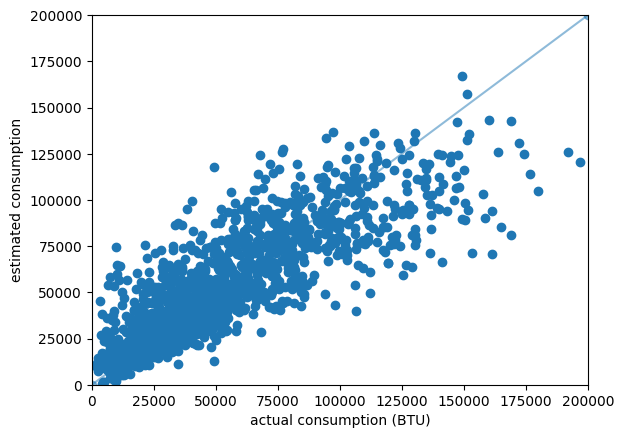

In [24]:
# Visualize model predictions vs. actuals
plt.scatter(y_test, predictions_df['est_consumption'])
plt.xlabel('actual consumption (BTU)')
plt.ylabel('estimated consumption')
plt.xlim([0, 200000])
plt.ylim([0, 200000])
plt.plot([0,200000],[0,200000],marker='o', alpha=0.5)
plt.rcParams['figure.figsize']=[fig_width, fig_height]
plt.savefig('preds_actuals.png')
plt.show()

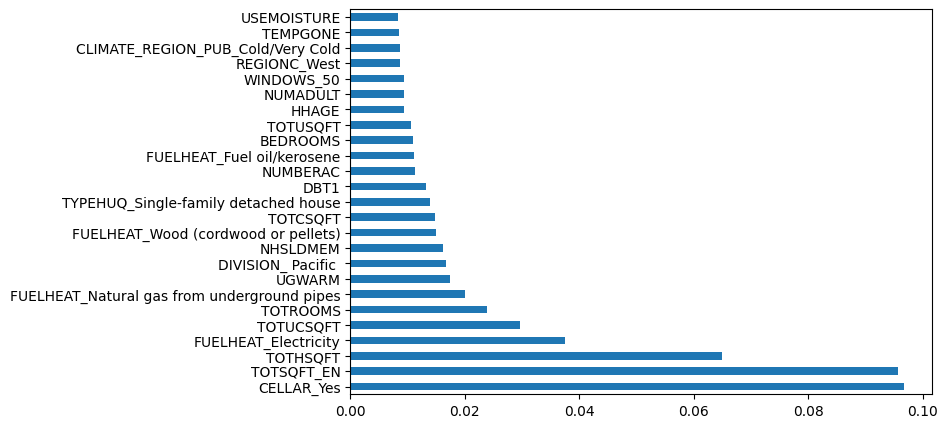

In [26]:
# getting feature importances
feat_importances = pd.Series(reg.feature_importances_, index=X_test.columns)
# feat_importances.to_excel('feature importances.xlsx')

feat_importances.nlargest(k).plot(kind='barh')
plt.savefig('feature importances.png')
plt.rcParams['figure.figsize']=[fig_width, fig_height]
plt.show()

In [27]:
print(X_train.columns)

Index(['BEDROOMS', 'NCOMBATH', 'NHAFBATH', 'OTHROOMS', 'TOTROOMS', 'DOOR1SUM',
       'UGASHERE', 'MONPOOL', 'RECBATH', 'MONTUB',
       ...
       'EQUIPAGE_Less than 2 years old', 'ATTICFIN_Yes', 'WALLTYPE_0ther',
       'WALLTYPE_Brick', 'WALLTYPE_Concrete or concrete block',
       'WALLTYPE_Shingle (composition)', 'WALLTYPE_Siding', 'WALLTYPE_Stone',
       'WALLTYPE_Stucco', 'WALLTYPE_Wood'],
      dtype='object', length=311)


In [28]:
y_train.head()

5097    85546.287
3352    41614.905
2856    38865.884
2847    77654.870
2274    92187.164
Name: REL_TOTALBTU, dtype: float64

In [29]:
print(feat_importances.index.values)

['BEDROOMS' 'NCOMBATH' 'NHAFBATH' 'OTHROOMS' 'TOTROOMS' 'DOOR1SUM'
 'UGASHERE' 'MONPOOL' 'RECBATH' 'MONTUB' 'FUELTUB' 'HEATHOME' 'DNTHEAT'
 'THERMAIN' 'PROTHERM' 'EQUIPMUSE' 'TEMPHOME' 'TEMPGONE' 'TEMPNITE'
 'EQUIPAUX' 'EQUIPAUXTYPE' 'FUELAUX' 'ATTCHEAT' 'GARGHEAT' 'MOISTURE'
 'USEMOISTURE' 'AIRCOND' 'COOLTYPE' 'CENACHP' 'AGECENAC' 'THERMAINAC'
 'PROTHERMAC' 'USECENAC' 'NUMBERAC' 'WWACAGE' 'USEWWAC' 'TEMPGONEAC'
 'TEMPNITEAC' 'ATTCCOOL' 'GARGCOOL' 'NUMCFAN' 'NUMFLOORFAN' 'NUMWHOLEFAN'
 'NUMATTICFAN' 'NOTMOIST' 'USENOTMOIST' 'H2OHEATAPT' 'WHEATAGE' 'WHEATSIZ'
 'MORETHAN1H2O' 'FUELH2O2' 'LGTINNUM' 'LGTIN4' 'LGTINCAN' 'LGTINCFL'
 'LGTINLED' 'LGTINCNTL' 'LGTOUTNUM' 'LGTOUTCNTL' 'AUDIT' 'AUDITCHG'
 'EELIGHTS' 'FREEAUDIT' 'REBATEAPP' 'RECYCAPP' 'TAXCREDITAPP' 'BENOTHER'
 'ESCWASH' 'ESDISHW' 'ESDRYER' 'ESFREEZE' 'ESFRIG' 'ESLIGHT' 'ESWATER'
 'ESWIN' 'SMARTTHERM' 'ELPAY' 'NGPAY' 'LPGPAY' 'FOPAY' 'SMARTMETER'
 'INTDATA' 'INTDATAACC' 'HHSEX' 'HHAGE' 'EMPLOYHH' 'SDESCENT'
 'HOUSEHOLDER_RACE' 'EDU

In [30]:
#create an empty dataframe with features from feature importances as columns to be filled in next step
iter_results_df=pd.DataFrame(columns=list(feat_importances.index))
iter_results_df["No_features"] = np.nan
iter_results_df['R2'] = np.nan
iter_results_df.head()

,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,DOOR1SUM,UGASHERE,MONPOOL,RECBATH,MONTUB,...,WALLTYPE_0ther,WALLTYPE_Brick,WALLTYPE_Concrete or concrete block,WALLTYPE_Shingle (composition),WALLTYPE_Siding,WALLTYPE_Stone,WALLTYPE_Stucco,WALLTYPE_Wood,No_features,R2


In [31]:
#feature selection

for i in range (feat_importances.count(), 0,-step):
    
    reg.fit(X_train, y_train)
    index=X_train.columns
    feat_importances= pd.Series(reg.feature_importances_, index=index)
    print(feat_importances.count(), reg.score(X_test, y_test))
    
    
    add_line=pd.Series(feat_importances)
    add_line.at['R2']=reg.score(X_test, y_test)
    add_line.at['No_features'] = i
    iter_results_df=pd.concat([iter_results_df, add_line.to_frame().T])
    
    
    print(feat_importances.nsmallest(step).index.values)
    X_train.drop(columns=feat_importances.nsmallest(step).index.values, inplace=True)
    X_test.drop(columns=feat_importances.nsmallest(step).index.values, inplace=True)

311 0.6808577187794187
['HEATHOME']


C:\Users\alkou\AppData\Local\Temp\ipykernel_22808\2768254892.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  iter_results_df=pd.concat([iter_results_df, add_line.to_frame().T])


310 0.6817801962323005
['USEEL']
309 0.6823897720006529
['AIRCOND']
308 0.6827090556045305
['DNTHEAT']
307 0.6820624902342729
['ENERGYASST']
306 0.6813144329938401
['COLDMA']
305 0.6810212058373839
['THERMAINAC']
304 0.6826956597599259
['ELOTHER']
303 0.6831564556868533
['FOOTHER']
302 0.6819694394223583
['IECC_CLIMATE_PUB_2B']
301 0.682014796166275
['NOACBROKE']
300 0.6828659119851996
['NOACEL']
299 0.6813723677155703
['WINDOWS_1 to 2']
298 0.6821352677178817
['EQUIPM_Portable electric heaters']
297 0.6812762575070985
['ROOFTYPE_Concrete tiles']
296 0.6831309151063536
['STUDIO_Yes']
295 0.6829030816512167
['WINDOWS_3 to 5']


KeyboardInterrupt: 

In [23]:
iter_results_df.head()

,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,DOOR1SUM,UGASHERE,MONPOOL,RECBATH,MONTUB,...,IECC_CLIMATE_PUB_5B-5C,IECC_CLIMATE_PUB_6A-6B,IECC_CLIMATE_PUB_7A-7B-7AK-8AK,BASEHEAT_Yes,ADQINSUL_Adequately insulated,ADQINSUL_Not insulated,ADQINSUL_Poorly insulated,ADQINSUL_Well insulated,No_features,R2
0,0.009541,0.003267,0.004968,0.007703,0.021554,0.002096,0.000347,0.003566,0.000276,0.003252,...,0.000830,0.003109,0.000425,0.003462,0.000397,0.000000,0.000963,0.001899,311.0,0.723124
0,0.009648,0.003004,0.005181,0.007935,0.021188,0.001846,0.000377,0.003846,0.000192,0.003260,...,0.000935,0.002984,0.000443,0.003516,0.000405,0.000000,0.001096,0.001582,310.0,0.721532
0,0.009628,0.003266,0.004976,0.007314,0.021709,0.001710,0.000136,0.004282,0.000380,0.002781,...,0.000821,0.002951,0.000331,0.003636,0.000357,0.000000,0.000881,0.001867,309.0,0.723940
0,0.009644,0.003065,0.005584,0.007358,0.021499,0.001919,0.000174,0.004162,0.000464,0.003144,...,0.000945,0.003052,0.000328,0.003436,0.000415,0.000055,0.001003,0.001971,308.0,0.725155
0,0.008984,0.003262,0.004871,0.007861,0.021856,0.001860,0.000343,0.004393,0.000358,0.003224,...,0.000835,0.002834,0.000139,0.003433,0.000347,0.000000,0.000949,0.001833,307.0,0.722074


In [24]:
iter_importances_df=iter_results_df.drop(columns = ['R2','No_features'])
iter_performance_df=iter_results_df[['R2','No_features']]

In [25]:
iter_importances_df.head()

,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,DOOR1SUM,UGASHERE,MONPOOL,RECBATH,MONTUB,...,IECC_CLIMATE_PUB_4C,IECC_CLIMATE_PUB_5A,IECC_CLIMATE_PUB_5B-5C,IECC_CLIMATE_PUB_6A-6B,IECC_CLIMATE_PUB_7A-7B-7AK-8AK,BASEHEAT_Yes,ADQINSUL_Adequately insulated,ADQINSUL_Not insulated,ADQINSUL_Poorly insulated,ADQINSUL_Well insulated
0,0.009541,0.003267,0.004968,0.007703,0.021554,0.002096,0.000347,0.003566,0.000276,0.003252,...,0.000348,0.004319,0.000830,0.003109,0.000425,0.003462,0.000397,0.000000,0.000963,0.001899
0,0.009648,0.003004,0.005181,0.007935,0.021188,0.001846,0.000377,0.003846,0.000192,0.003260,...,0.000407,0.003710,0.000935,0.002984,0.000443,0.003516,0.000405,0.000000,0.001096,0.001582
0,0.009628,0.003266,0.004976,0.007314,0.021709,0.001710,0.000136,0.004282,0.000380,0.002781,...,0.000420,0.004020,0.000821,0.002951,0.000331,0.003636,0.000357,0.000000,0.000881,0.001867
0,0.009644,0.003065,0.005584,0.007358,0.021499,0.001919,0.000174,0.004162,0.000464,0.003144,...,0.000397,0.004128,0.000945,0.003052,0.000328,0.003436,0.000415,0.000055,0.001003,0.001971
0,0.008984,0.003262,0.004871,0.007861,0.021856,0.001860,0.000343,0.004393,0.000358,0.003224,...,0.000361,0.004305,0.000835,0.002834,0.000139,0.003433,0.000347,0.000000,0.000949,0.001833


In [26]:
iter_performance_df.head()

,R2,No_features
0,0.723124,311.0
0,0.721532,310.0
0,0.723940,309.0
0,0.725155,308.0
0,0.722074,307.0


In [27]:
#reordering columns by max(importance) to get cleaner charts lateron
cols=iter_results_df.max().sort_values(ascending=False).index
iter_results_df=iter_results_df[cols]

In [28]:
iter_results_df['No_features'] = iter_performance_df['No_features']
iter_results_df.head()

,No_features,TOTSQFT_EN,R2,TOTHSQFT,TOTUCSQFT,DBT1,TOTCSQFT,CELLAR_Yes,FUELHEAT_Electricity,TOTROOMS,...,FUELHEAT_Not Applicable,FUELH2O_Solar,USEEL,ELOTHER,STUDIO_Yes,FOOTHER,DNTHEAT,HEATHOME,SOLWATER,NOHEATBULK
0,311.0,0.098594,0.723124,0.077708,0.031267,0.014327,0.022312,0.085323,0.040254,0.021554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,310.0,0.099559,0.721532,0.077110,0.030267,0.014349,0.022548,0.085141,0.040490,0.021188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
0,309.0,0.099474,0.723940,0.080758,0.031058,0.014784,0.022531,0.085117,0.040295,0.021709,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
0,308.0,0.098867,0.725155,0.081185,0.030229,0.015068,0.021447,0.084749,0.040432,0.021499,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN
0,307.0,0.099701,0.722074,0.078765,0.030748,0.015224,0.021783,0.085757,0.040393,0.021856,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN


In [29]:
iter_results_df=iter_results_df.reset_index()
iter_results_df.fillna(0, inplace=True)
iter_results_df.drop(columns = ['index'], inplace=True)
iter_results_df.to_excel('iteration results.xlsx')
iter_results_df.head()

,No_features,TOTSQFT_EN,R2,TOTHSQFT,TOTUCSQFT,DBT1,TOTCSQFT,CELLAR_Yes,FUELHEAT_Electricity,TOTROOMS,...,FUELHEAT_Not Applicable,FUELH2O_Solar,USEEL,ELOTHER,STUDIO_Yes,FOOTHER,DNTHEAT,HEATHOME,SOLWATER,NOHEATBULK
0,311.0,0.098594,0.723124,0.077708,0.031267,0.014327,0.022312,0.085323,0.040254,0.021554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,310.0,0.099559,0.721532,0.077110,0.030267,0.014349,0.022548,0.085141,0.040490,0.021188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,309.0,0.099474,0.723940,0.080758,0.031058,0.014784,0.022531,0.085117,0.040295,0.021709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,308.0,0.098867,0.725155,0.081185,0.030229,0.015068,0.021447,0.084749,0.040432,0.021499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,307.0,0.099701,0.722074,0.078765,0.030748,0.015224,0.021783,0.085757,0.040393,0.021856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
iter_results_df.index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [31]:
iter_results_df.values

array([[3.11000000e+02, 9.85941908e-02, 7.23124148e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.10000000e+02, 9.95585390e-02, 7.21531740e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.09000000e+02, 9.94741707e-02, 7.23939963e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.00000000e+00, 4.17601846e-01, 3.80671667e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 5.71491419e-01, 3.34352241e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 3.13815655e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [32]:
iter_results_df.shape

(311, 313)

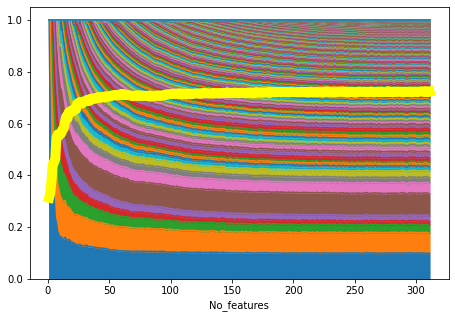

In [33]:
# Plotting the result
ax=iter_results_df.drop(columns='R2').plot.area(x = 'No_features', legend=None)
ax=iter_results_df.plot.line(x='No_features', y = 'R2', legend=None, color='yellow', marker=None, linewidth=10, ax=ax)
plt.rcParams['figure.figsize'] = [fig_width, fig_height]
plt.savefig('feature reduction.png')


In [34]:
# PART TWO
# Importance of test size

# Performing train test split
target=houses_df['REL_TOTALBTU']
data=houses_df.drop(columns=['REL_TOTALBTU'])
iter_train_size_df=pd.Series(dtype = 'float')
add_line=pd.Series(dtype = 'float')

for i in range (1, 100, 1):
    X_train, X_test, y_train, y_test = train_test_split(data, target, train_size = i/100)
    reg.fit(X_train, y_train)
    score=reg.score(X_test, y_test)
    
    
    #add_line=pd.Series(dtype = 'float')
    add_line.at['R2']=reg.score(X_test, y_test)
    add_line.at['train_size'] = i/100
    iter_train_size_df=pd.concat([iter_train_size_df, add_line.to_frame().T])
    print(add_line)

R2            0.471645
train_size    0.010000
dtype: float64
R2            0.468661
train_size    0.020000
dtype: float64
R2            0.532772
train_size    0.030000
dtype: float64
R2            0.548748
train_size    0.040000
dtype: float64
R2            0.575083
train_size    0.050000
dtype: float64
R2            0.569483
train_size    0.060000
dtype: float64
R2            0.575076
train_size    0.070000
dtype: float64
R2            0.601114
train_size    0.080000
dtype: float64
R2            0.603982
train_size    0.090000
dtype: float64
R2            0.572535
train_size    0.100000
dtype: float64
R2            0.608276
train_size    0.110000
dtype: float64
R2            0.573598
train_size    0.120000
dtype: float64
R2            0.617536
train_size    0.130000
dtype: float64
R2            0.623704
train_size    0.140000
dtype: float64
R2            0.641358
train_size    0.150000
dtype: float64
R2            0.640891
train_size    0.160000
dtype: float64
R2            0.62889
tr

In [35]:
# Check data frame iter_train_size if it contains R2 and train size.
iter_train_size_df.head()

,0,R2,train_size
0,NaN,0.471645,0.01
0,NaN,0.468661,0.02
0,NaN,0.532772,0.03
0,NaN,0.548748,0.04
0,NaN,0.575083,0.05


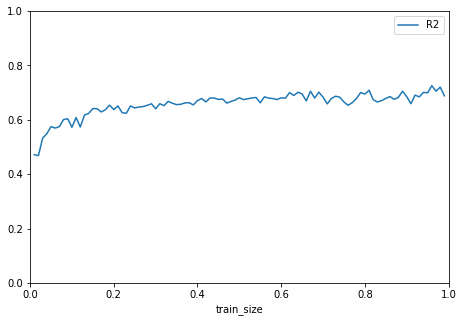

In [36]:
# Plotting the result and save as .png
fig=iter_train_size_df.plot.line(x = 'train_size', y = 'R2', legend=True)
plt.xlim(0, 1)
plt.ylim(0,1)
plt.rcParams['figure.figsize'] = [fig_width, fig_height]
plt.rcParams['legend.loc'] = 'lower right'
plt.savefig('test size iteration.png')
plt.show()